In [24]:
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from collections import Counter
import re
import spacy

%matplotlib inline
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle

import gensim
from gensim import corpora, models, similarities
import pyLDAvis.gensim as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [12]:
with open('C:\\Users\\ryan\\Desktop\\python\\secrets.json') as f:
    secrets = json.load(f)
    
consumer_token = secrets["consumer_token"]
consumer_secret = secrets["consumer_secret"]
access_token = secrets["access_token"]
access_token_secret = secrets["access_token_secret"]

auth = tweepy.OAuthHandler(consumer_token, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

Let's try to classify tweets of 10 different politicians, including: Trump, Hillary Clinton, John McCain, Bernie Sanders, Mike Huckabee, Barack Obama, Newt Gingrich, John Kasich, Kellyanne Conway, and Bill de Blasio.

In [2]:
handles = ['realDonaldTrump', 'HillaryClinton', 'SenJohnMcCain', 'SenSanders', 'GovMikeHuckabee', 
           'BarackObama', 'newtgingrich', 'MikeBloomberg', 'KellyannePolls', 'NYCMayor']

In [172]:
#Open a blank .json file for each author, will append tweets later
for handle in handles:
    with open(f'C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\Capstone\\{handle}2.json', 'w') as f:
        try: 
            json.load(f)
        except ValueError:
            empty = [] #Just added this line to handle exceptions, does nothing

In [173]:
#Twitter's API only allows for 200 records per call
TWEETS_PER_CALL = 200 

def save_tweets(screen_nm, tweets):
    # 'a' appends to the .json we wrote with 'w' above
    with open(f'C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\Capstone\\{screen_nm}2.json', 'a') as f:
        for tweet in tweets:
            json.dump([tweet.text, screen_nm], f); f.write('\n')

def get_tweets(screen_nm, desired_ct):
    
    #desired_ct is the number of tweets the user wants to include
    tweet_list = []

    #grab the current maximum tweet id for provided screen name, which will be the id of the first tweet stored in the object
    curr_max_id = api.user_timeline(screen_name = screen_nm)[0].id 
    
    #may have to do more than 1 call to the API (if user wants > TWEETS_PER_CALL tweets)
    remaining = desired_ct
        
    while remaining > 0:
        tweets = api.user_timeline(screen_name = screen_nm, count = min(remaining, TWEETS_PER_CALL), max_id = curr_max_id, include_rts=False)
        
        #save these tweets in a json file for later, in case kernel crashes or want to reference at a later date
        save_tweets(screen_nm, tweets)
        
        for tweet in tweets:
            tweet_list.append([tweet.text, screen_nm])
                
        remaining = remaining - min(remaining, TWEETS_PER_CALL)
        
        #re-set the maximum id for every TWEETS_PER_CALL tweets, so that we don't include duplicate tweets
        curr_max_id = tweets[-1].id 

    return tweet_list

In [177]:
#Create tweet lists. Twitter's API states that users can only access up to 3,200 tweets for each account.

trump = get_tweets('realDonaldTrump', 3200)
clinton = get_tweets('HillaryClinton', 3200)
mccain = get_tweets('SenJohnMcCain', 3200)
bernie = get_tweets('SenSanders', 3200)
huck = get_tweets('GovMikeHuckabee', 3200)
obama = get_tweets('BarackObama', 3200)
newt = get_tweets('newtgingrich', 3200)
bloom = get_tweets('MikeBloomberg', 3200)
conway = get_tweets('KellyannePolls', 3200)
bdb = get_tweets('NYCMayor', 3200)

In [3]:
#Combine all tweets into 1 list

full_tweets = []
for handle in handles:
    with open('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\Capstone\\{}2.json'.format(handle)) as f: 
        full_tweets.append([json.loads(line) for line in f])
        
#Only want the first 2100 from each author (retweets caused the full amount for each author to be < 3200, and each has at least
#2100 non RTs)
all_tweets = []
for auth in full_tweets:
    all_tweets.extend(auth[:2100])
    
#Store in dataframe
tweet_df = pd.DataFrame(all_tweets, columns = ['Tweets', 'Author'])

In [4]:
tweet_df.head()

,Tweets,Author
0,It was a great privilege to meet with Presiden...,realDonaldTrump
1,It was wonderful to have President Petro Poros...,realDonaldTrump
2,It was a pleasure to have President Ashraf Gha...,realDonaldTrump
3,Governor @RicardoRossello- \nWe are with you a...,realDonaldTrump
4,Senator (Doctor) Bill Cassidy is a class act w...,realDonaldTrump


In [5]:
#Concatenate all tweets into a single string for BoW purposes
#Load spaCy to prepare to tokenize our tweets (for more interesting features later on)
nlp = spacy.load('en') 

tweets_full = ' '.join(tweet_df['Tweets'])
tweets_full = nlp(tweets_full)

In [6]:
def bag_of_words(doc):
    allwords = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_url and 
                not token.like_num and not token.is_space and token.is_ascii and len(token.lemma_) > 1]
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(10000)]

In [7]:
#Create our bag of desired words. All tweets concatentated for this task. Only use training set, though!
Tweet_train, Tweet_test = train_test_split(tweets_full, test_size=0.25, random_state = 42)

bow = bag_of_words(Tweet_train)

#Let's clean this up a bit 
replace_words = [r'/n', r'\\n', r'\n', r'--', r'-', 'https:\/\/t\.co\/[\w\d]+', r'amp', r'&', r'w/', "'s"]
bow = [re.sub('|'.join(replace_words), '', word) for word in bow]

In [8]:
#Tokenize our tweets using spaCy (for more interesting features later on)
all_tweets_nlp = []
all_tweets_nlp.append([nlp(tweet[0]) for tweet in all_tweets])
all_tweets_nlp.append([nlp(tweet[1]) for tweet in all_tweets])

In [9]:
#Create dataframe with counts of our bag of words as features 
def bow_features(sentences, bow):
    
    partsofspeechlist = []
    ent_list = []
    
    for sent in sentences[0]:
        for token in sent:
                partsofspeechlist.append(token.pos_)

    parts = (set(partsofspeechlist))

    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns = set(list(bow) + list(parts)))
    df['Tweet'] = sentences[0]
    df['Author'] = sentences[1]
    df.loc[:, bow] = 0
    df['tweet_length'] = 0
    df['tweet_punct_count'] = 0 
    df['upper_case'] = 0 
    df.loc[:, parts] = 0
    
    for i, sent in enumerate(sentences[0]):

        tweet_len = 0    
        num_punct = 0
        
        # Populate the row with word counts (only include the ones from our bag of words)
        words = [token.lemma_ for token in sent
                 if token.lemma_ in bow]
        
        #"words" collects all bow matches from each sentence
        for word in words:
            df.loc[i, word] += 1
        
        #Add part of speech counter and tweet length
        for token in sent:
            df.loc[i, token.pos_] += 1
            if not token.is_punct:
                tweet_len += 1
            else:
                num_punct += 1
            
        #Create a feature for all CAPS words  
            if ((str(token).isupper()) & (len(str(token)) > 1)):
                df.loc[i, 'upper_case'] += 1


        df.loc[i, 'tweet_length'] = tweet_len
        df.loc[i, 'tweet_punct_count'] = num_punct

        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))

    return df

In [10]:
#Call our method to build our bag of words feature df
df = bow_features(all_tweets_nlp, bow)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500
Processing row 11000
Processing row 11500
Processing row 12000
Processing row 12500
Processing row 13000
Processing row 13500
Processing row 14000
Processing row 14500
Processing row 15000
Processing row 15500
Processing row 16000
Processing row 16500
Processing row 17000
Processing row 17500
Processing row 18000
Processing row 18500
Processing row 19000
Processing row 19500
Processing row 20000
Processing row 20500


# Basic Bag of Words Model

In [228]:
#Create a basic model to guage where our starting accuracy is at

rfc = ensemble.RandomForestClassifier()

X = np.array(df.drop(['Tweet', 'Author'], 1))

#y needs to be str or int, cannot be spacy doc, so convert here
y = df['Author'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

train = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.995365079365

Test set score: 0.549904761905


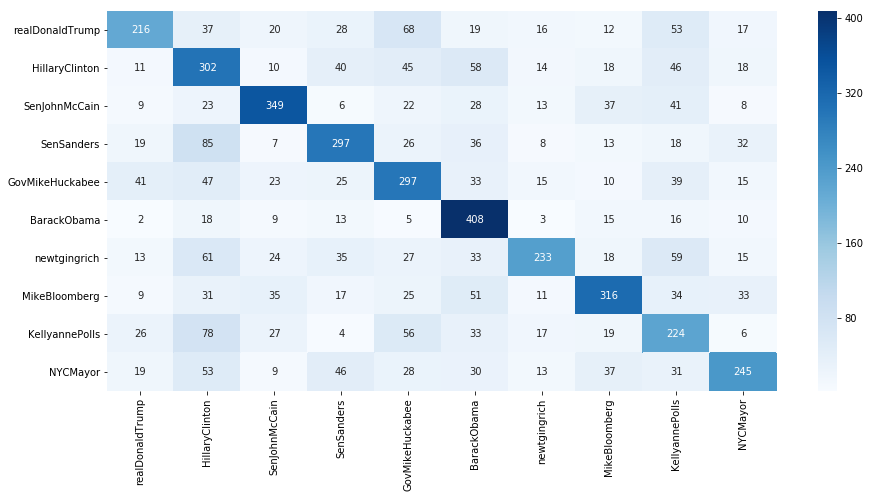

In [229]:
#Confusion matrix for model random forest performance visualization

conf = confusion_matrix(y_test, y_pred, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

# Basic TF-IDF Model

In [17]:
#Try TF-IDF to see if we can increase prediction accuracy. Also experiment by increasing the minimum document frequency 
#to reduce the feature space...

X_train, X_test, y_train, y_test = train_test_split(tweet_df['Tweets'], tweet_df['Author'], test_size = 0.25, random_state = 42)

vectorizer1 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=2, # only use words that appear at least 2x
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

X_train_tfidf = vectorizer1.fit_transform(X_train)
X_test_tfidf = vectorizer1.transform(X_test)

fit = rfc.fit(X_train_tfidf, y_train)
y_pred = rfc.predict(X_test_tfidf)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))

Training set score: 0.989841269841

Test set score: 0.641714285714


In [18]:
#Try a GBM classifier here, using the standard TF-IDF approach above

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_tfidf, y_train)
tfidf_pred = clf.predict(X_test_tfidf.toarray())
tfidf_pred_prob = clf.predict_proba(X_test_tfidf.toarray())

print('Training set score:', clf.score(X_train_tfidf.toarray(), y_train))
print('\nTest set score:', clf.score(X_test_tfidf.toarray(), y_test))

Training set score: 0.736253968254

Test set score: 0.649904761905


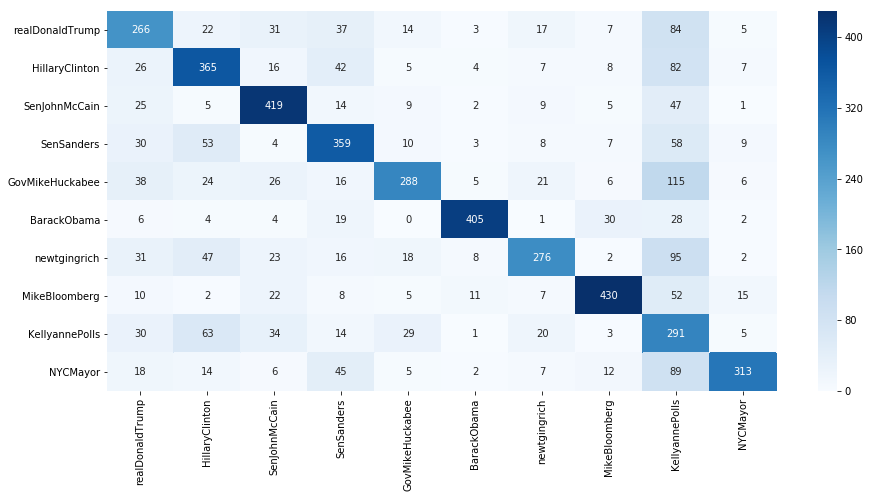

In [19]:
#Confusion matrix for GBM performance visualization on TF-IDF

conf = confusion_matrix(y_test, tfidf_pred, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

# TF-IDF With Customized Analyzer (using spaCy tokenizer)

In [20]:
#Try TF-IDF to see if we can increase prediction accuracy. Also experiment by increasing the minimum document frequency 
#to reduce the feature space...

#Use 'analyzer' function in tfidf vectorizer to take advantage of our spacy lemmas & other exclusions we applied in the basic 
#BoW approach above.

nlp = spacy.load('en')

def bag_of_words_tfidf(doc):
    #https://github.com/scikit-learn/scikit-learn/blob/ef5cb84a/sklearn/feature_extraction/text.py#L792
    #Lines 790-792 show that analyzer takes 1 doc input at a time (not the full corpus) - so pass "doc" here instead of 
    tweets_full = nlp(doc)
    
    allwords = (token.lemma_ for token in tweets_full if not token.is_stop and not token.is_punct and not token.like_url and 
                not token.like_num and not token.is_space and token.is_ascii and len(token.lemma_) > 1)

    return allwords

#Can define a new function that points to first function and creates a vocabulatry for the full training set
 

X_train, X_test, y_train, y_test = train_test_split(tweet_df['Tweets'], tweet_df['Author'], test_size = 0.25, random_state = 42)

vectorizer2 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=2, # only use words that appear at least 2x
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,
                             analyzer = bag_of_words_tfidf,
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

X_train_tfidf = vectorizer2.fit_transform(X_train)
X_test_tfidf = vectorizer2.transform(X_test)

fit = rfc.fit(X_train_tfidf, y_train)
y_pred = rfc.predict(X_test_tfidf)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))


Training set score: 0.989206349206

Test set score: 0.615047619048


In [21]:
#Try a GBM classifier here, using the CUSTOMIZED TF-IDF approach above

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_tfidf, y_train)
spacy_tok_pred = clf.predict(X_test_tfidf.toarray())
spacy_tok_pred_prob = clf.predict_proba(X_test_tfidf.toarray())

print('Training set score:', clf.score(X_train_tfidf.toarray(), y_train))
print('\nTest set score:', clf.score(X_test_tfidf.toarray(), y_test))

Training set score: 0.718095238095

Test set score: 0.63619047619


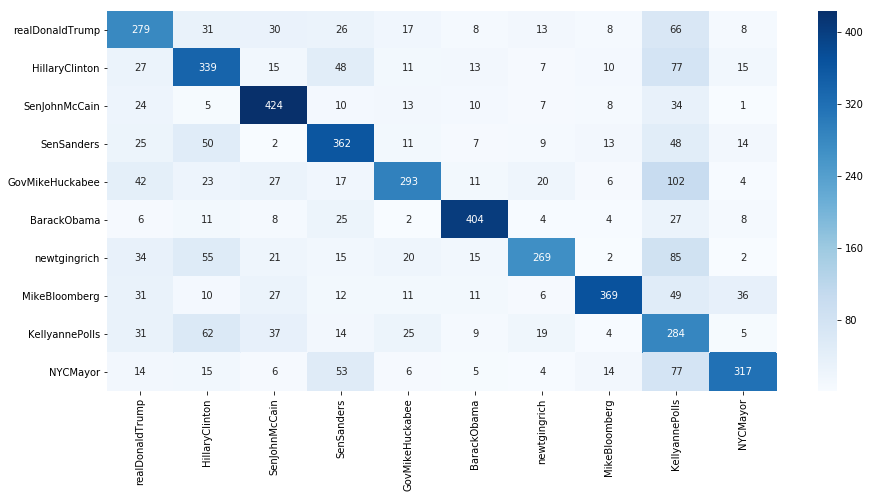

In [22]:
#Confusion matrix for GBM performance visualization on CUSTOMIZED TF-IDF

conf = confusion_matrix(y_test, spacy_tok_pred, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

# Detailed Comparison of standard TF-IDF tokenizer vs spaCy tokenizer

In [13]:
#Set up dataframe to enable easy comparisons between default TF-IDF and SpaCy

pd.options.display.max_colwidth = 200
comparison = pd.DataFrame()
comparison['Tweet'] = X_test
comparison['TF-IDF Pred'] = tfidf_pred
comparison['TF-IDF Probs'] = [pred for pred in tfidf_pred_prob]
comparison['SpaCy Pred'] = spacy_tok_pred
comparison['SpaCy Probs'] = [pred for pred in spacy_tok_pred_prob]
comparison['Author'] = y_test
comparison.reset_index(drop = True, inplace = True)

In [63]:
#Find the tweets where the max author probability changed the most
prob_changes = []
for i, row in enumerate(comparison['TF-IDF Probs']):
    row_changes = []
    for j, auth in enumerate(comparison['TF-IDF Probs'][i]):
        row_changes.append((comparison['SpaCy Probs'][i][j] - comparison['TF-IDF Probs'][i][j]))
    prob_changes.append(row_changes)

In [64]:
#Get author index for tweet with highest change in particular author probability
max_change_idx = []
for row in prob_changes:
    max_chg = 0
    for i, auth_chg in enumerate(row):
        if abs(auth_chg) > abs(max_chg):
            max_chg = auth_chg
            idx = i
    max_change_idx.append([max_chg, idx])

In [65]:
#Determine order of classification index
auth_index = clf.classes_
auth_dict = {}
for i, auth in enumerate(auth_index):
    auth_dict[i] = auth

In [66]:
max_change_author = []
max_prob_change = []
for i, row in enumerate(max_change_idx):
    max_change_author.append(auth_dict.get(row[1]))
    max_prob_change.append(max_change_idx[i][0])

In [144]:
inv_auth_dict = {v: k for k, v in auth_dict.items()}
prob_change_true = []
for i, row in enumerate(prob_changes):
    prob_change_true.append(prob_changes[i][inv_auth_dict.get(comparison['Author'][i])])

In [150]:
comparison['Max Prob Change'] = max_prob_change
comparison['Max Prob Change Author'] = max_change_author
comparison['Prob Change True Author'] = prob_change_true

In [151]:
#Top instances where spaCy moved significantly away from the correct author

(comparison[
              
              (comparison['Max Prob Change Author'] == comparison['Author']) 
            & (comparison['Max Prob Change'] < 0)
           ]
).sort_values(by = 'Max Prob Change', ascending = True).head(5)

,Tweet,TF-IDF Pred,TF-IDF Probs,SpaCy Pred,SpaCy Probs,Author,Max Prob Change,Max Prob Change Author,Prob Change True Author
1616,#OneBostonDay celebrates resiliency over tragedy. @Marty_Walsh has launched an important new tradition in Boston: http://t.co/dA91AT0FjD,MikeBloomberg,"[0.00838822086938, 0.00559563555962, 0.00396040246683, 0.00632678977452, 0.951976836304, 0.00461117758236, 0.00385026077451, 0.00471869109539, 0.00494975427201, 0.00562223130136]",KellyannePolls,"[0.0653018705975, 0.114416147858, 0.0915073616071, 0.132187375836, 0.0910656323864, 0.0958431830342, 0.0790941670596, 0.0979916038756, 0.107462582313, 0.125130075433]",MikeBloomberg,-0.860911,MikeBloomberg,-0.860911
2270,"""Remember, when they go low, we go high.” —@FLOTUS: https://t.co/tTgeqxNqYm",HillaryClinton,"[0.00488539198949, 0.0117968376808, 0.914076546241, 0.0133382725189, 0.00582823842104, 0.00972138247334, 0.00811720150493, 0.00994804474397, 0.0104351770383, 0.0118529073881]",KellyannePolls,"[0.0653018705975, 0.114416147858, 0.0915073616071, 0.132187375836, 0.0910656323864, 0.0958431830342, 0.0790941670596, 0.0979916038756, 0.107462582313, 0.125130075433]",HillaryClinton,-0.822569,HillaryClinton,-0.822569
303,NYC became great because we dared to dream bigger than anyone else. @Cornell_Tech is part of that tradition http://t.co/MzBRpFkLWS,MikeBloomberg,"[0.040545040628, 0.00526179915508, 0.00372412429861, 0.00594933260668, 0.903849507312, 0.0172917700261, 0.00362055367514, 0.00443717332093, 0.00465445123593, 0.0106662477417]",NYCMayor,"[0.0325571522157, 0.0570437555258, 0.0456222627842, 0.0659038474196, 0.0999444261912, 0.286972563842, 0.0394334926821, 0.0488550715936, 0.0535769590953, 0.270090468651]",MikeBloomberg,-0.803905,MikeBloomberg,-0.803905
1478,Great to see the progress made @Cornell_Tech site on Roosevelt Island today http://t.co/fSLa7Pt0yF,MikeBloomberg,"[0.0656159686952, 0.00514210775054, 0.003639410752, 0.00581400171419, 0.883289426276, 0.0136524534882, 0.00353819607429, 0.00433623987757, 0.00454857531985, 0.0104236200518]",NYCMayor,"[0.0888848194519, 0.0719688828577, 0.0575590308834, 0.0831471601246, 0.0905670063856, 0.226807172782, 0.0497510093672, 0.0616376830753, 0.0675950217068, 0.202082213365]",MikeBloomberg,-0.792722,MikeBloomberg,-0.792722
1245,Happy birthday @MayorofLondon &amp; @Anne_Hidalgo. Thank you both for your friendship and inspiring leadership. http://t.co/4LI7CqT5rM,MikeBloomberg,"[0.0184290157251, 0.00472569927491, 0.00334469085172, 0.00597057780193, 0.934270986197, 0.00333408684258, 0.0111622024992, 0.0030670868834, 0.00418023116856, 0.0115154227554]",SenJohnMcCain,"[0.049404707273, 0.0865625477571, 0.0692307030742, 0.118895361243, 0.161040937223, 0.0675400118324, 0.183506839206, 0.0571566334899, 0.0813017662954, 0.125360492606]",MikeBloomberg,-0.773230,MikeBloomberg,-0.773230


In [152]:
#Top instances where spaCy moved significantly toward the correct author

(comparison[
              
              (comparison['Max Prob Change Author'] == comparison['Author']) 
            & (comparison['Max Prob Change'] > 0)
           ]
).sort_values(by = 'Max Prob Change', ascending = False).head(5)

,Tweet,TF-IDF Pred,TF-IDF Probs,SpaCy Pred,SpaCy Probs,Author,Max Prob Change,Max Prob Change Author,Prob Change True Author
530,Headed to @foxnews now. Will discuss tonight's results on @FoxBusiness at 9:30pET and on FNC at 10pET with @seanhannity,GovMikeHuckabee,"[0.0380179639082, 0.351497065478, 0.0649747987184, 0.103798009313, 0.0453551646248, 0.0756514868826, 0.063167801993, 0.0774153654093, 0.0878833982086, 0.0922389454643]",newtgingrich,"[0.00219746946972, 0.00749709539018, 0.00307930893167, 0.00444822973711, 0.00306444432722, 0.00322521340769, 0.00266159324007, 0.00329750979313, 0.966546851612, 0.00398228409078]",newtgingrich,0.878663,newtgingrich,0.878663
2265,"Helen Marshall devoted her life to public service across education, arts &amp; economic dev - our city is better for it. https://t.co/5S0w6MT1SU",NYCMayor,"[0.0256400648246, 0.061913493024, 0.0438202859871, 0.0782232016015, 0.0966586265688, 0.310942884703, 0.176623143831, 0.0892034628986, 0.0547670721807, 0.0622077643812]",MikeBloomberg,"[0.00607304205265, 0.0106406458358, 0.00851013990996, 0.0146151362603, 0.878407858592, 0.0187167606485, 0.0225574608769, 0.0188479523211, 0.00999396763831, 0.0116370358644]",MikeBloomberg,0.781749,MikeBloomberg,0.781749
327,"Great to meet you too! MT @MayorLevine: Had the pleasure of meeting @MikeBloomberg! Great Mayor, philanthropist, &amp; entrepreneur #CityLab2014",SenJohnMcCain,"[0.0291690685381, 0.070435037267, 0.0498515481166, 0.088989553825, 0.138630077417, 0.0496934987497, 0.275706303072, 0.0457139496964, 0.0623050094841, 0.189505953834]",MikeBloomberg,"[0.00428858398751, 0.00751407662791, 0.00600958291296, 0.010320731982, 0.890166641423, 0.0058628221732, 0.0159293422764, 0.00496149125649, 0.00705741360157, 0.047889313759]",MikeBloomberg,0.751537,MikeBloomberg,0.751537
3957,Joining @MarosSefcovic &amp; @CFigueres to announce that city leaders from all regions of the world will join the… https://t.co/N7gyWXwr5q,newtgingrich,"[0.0296873510873, 0.0716865428001, 0.0507373215998, 0.090570740168, 0.0993537773996, 0.126562662612, 0.169325143361, 0.0465262054032, 0.243522990655, 0.0720272649144]",MikeBloomberg,"[0.00892481903696, 0.0156372766231, 0.0125063284623, 0.0214781068849, 0.846083604078, 0.0201062143997, 0.033149985545, 0.0103251823321, 0.0146869315015, 0.0171015511364]",MikeBloomberg,0.746730,MikeBloomberg,0.746730
2966,EpiPens can be the difference between life and death. There's no justification for these price hikes. https://t.co/O6RbVR6Qim -H,KellyannePolls,"[0.0518218294922, 0.125135037712, 0.0885663669049, 0.141485818473, 0.0618230795696, 0.10311963217, 0.086103271395, 0.105523953781, 0.11069121298, 0.125729797522]",HillaryClinton,"[0.0120923429915, 0.022341323188, 0.826190403599, 0.0244779372033, 0.0202651525498, 0.0177478628413, 0.0146463460841, 0.02390599083, 0.0198994973985, 0.0184331433149]",HillaryClinton,0.737624,HillaryClinton,0.737624


In [160]:
#Summarize the spaCy tokenizer performance by author

better = pd.DataFrame((comparison['Prob Change True Author'] > 0).groupby(comparison.Author).sum())
worse = pd.DataFrame((comparison['Prob Change True Author'] <= 0).groupby(comparison.Author).sum())

better.columns=['Better']
worse.columns=['Worse']

better.reset_index(inplace=True)
worse.reset_index(inplace=True)

overall = pd.merge(better,worse,how='inner', on='Author')
overall['Total'] = overall.Better + overall.Worse
overall.head(10)

,Author,Better,Worse,Total
0,BarackObama,159.0,340.0,499.0
1,GovMikeHuckabee,222.0,323.0,545.0
2,HillaryClinton,259.0,303.0,562.0
3,KellyannePolls,180.0,310.0,490.0
4,MikeBloomberg,219.0,343.0,562.0
5,NYCMayor,186.0,325.0,511.0
6,SenJohnMcCain,228.0,308.0,536.0
7,SenSanders,238.0,303.0,541.0
8,newtgingrich,242.0,276.0,518.0
9,realDonaldTrump,197.0,289.0,486.0


Strangely, the spaCy lemma tokenization does not seem to improve classification probabilities for any author or particular type of tweet (no discernable patterns). Due to its slightly worse classification performance on the test set and lack of any other valid reason to proceed with the customized TF-IDF, I will work with the standard TF-IDF tokenizer (vectorizer1) going forward.

I also compared tweet clusters using K-Means and LSA, but did not notice any significant difference between the resultant clusters, further strengthening argument to proceed with default TF-IDF.


# TF-IDF Centroid Approach

In [18]:
#What if we calculate the tf-idf centroid for each author using the training set, and find the consine similarity 
#for each tweet / author-centroid pair. These new features might add some predictive power to our model. Let's try.

#We will use the standard TF-IDF approach (rather than the customized spaCy tokenization) due to superior performance

X_train, X_test, y_train, y_test = train_test_split(tweet_df['Tweets'], tweet_df['Author'], test_size = 0.25, random_state = 42)

X_train_tfidf = vectorizer1.fit_transform(X_train)
X_test_tfidf = vectorizer1.transform(X_test)

#Find the average (centroid) by author for each item in the train tfidf matrix. Then compare test vectors to the pre-calculated
#centroid and return cosine similarity score for each author

centroids = []
for author in handles:
    auth_tweets = []
    for tweet, auth in zip(X_train_tfidf.toarray(), y_train):
        if auth == author:
            auth_tweets.append(tweet)
    #Now take the average of the tf-idf rows for this author
    centroids.append([np.mean(auth_tweets, axis = 0), author])

In [19]:
#Compute the similarity scores for the train set first

centroid_sim_train = pd.DataFrame(columns = handles)

for i, vector in enumerate(X_train_tfidf.toarray()):
    for cen, author in centroids:
        centroid_sim_train.loc[i, author] = cosine_similarity(vector, cen)
        
#Do the same for the test set

centroid_sim_test = pd.DataFrame(columns = handles)

for i, vector in enumerate(X_test_tfidf.toarray()):
    for cen, author in centroids:
        centroid_sim_test.loc[i, author] = cosine_similarity(vector, cen)

In [74]:
#Now feed these features back into the Random Forest model

X_train_new = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), centroid_sim_train], axis = 1)
X_test_new = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), centroid_sim_test], axis = 1)

fit = rfc.fit(X_train_new, y_train)
y_pred = rfc.predict(X_test_new)

print('Training set score:', rfc.score(X_train_new, y_train))
print('\nTest set score:', rfc.score(X_test_new, y_test))

Training set score: 0.991492063492

Test set score: 0.656761904762


The new features appear to have helped the Random Forest model a bit here (we saw 64.5% accuracy without using these features above)... let's check to see if GBM does any better.

In [75]:
#Try a GBM classifier using the TF-IDF CENTROID approach above

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_new, y_train)
y_pred = clf.predict(X_test_new)
y_pred_prob = clf.predict_proba(X_test_new)

print('Training set score:', clf.score(X_train_new, y_train))
print('\nTest set score:', clf.score(X_test_new, y_test))

Training set score: 0.830920634921

Test set score: 0.700380952381


Voila! The model accuracy is up to 70%! Let's move on to clustering for now. Later, I will optimize and cross-validate the results to produce the best model.

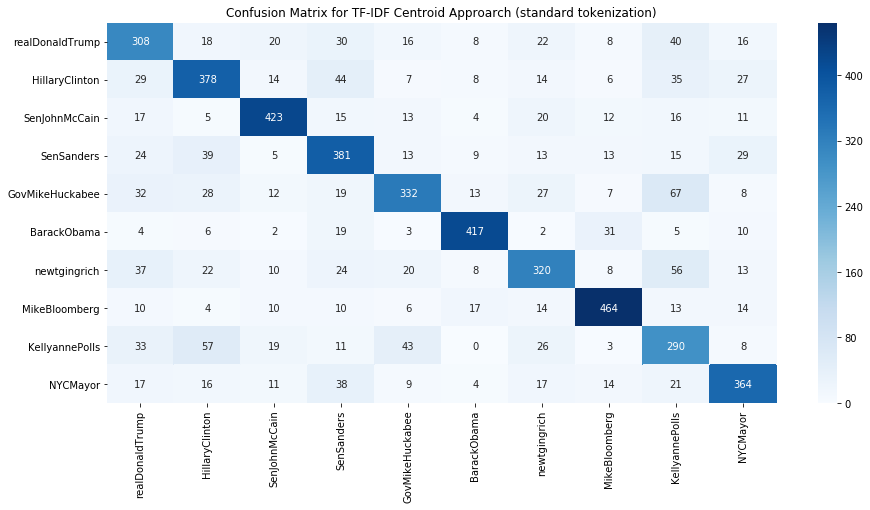

In [76]:
#Confusion matrix for TF-IDF centroid approach (using GBM model)

conf = confusion_matrix(y_test, y_pred, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
plt.title('Confusion Matrix for TF-IDF Centroid Approarch (standard tokenization)')
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

At this point, we have a rudimentary supervised model that is able to correctly classify ~70% of the tweets in the test set. Before beginning testing alternate supervised models (SVC, KNN, Neural Networks, etc) and optimizing to improve accuracy, I will implement some unsuperivsed clustering algorithms to explore how authors are typically clustered, and determine if these clusters can be used as features to improve this model.

Following that, I will explore different dimensionality reduction techniques (Latent Semantic Analysis [LSA, which uses PCA], Latent Dirichlet Allocation [LDA, which is probabalistic]) with the hopes of identifying topics. One of LDA's drawbacks is that you must specify the number of topics beforehand. Perhaps we can use some unsupervised clustering algorithm to find a number of topics that makes sense. 


# Unsupervised Clustering Using K-Means (MiniBatch): High Dimensional Data

Based on trial-and-error techinques, it was determined that a smaller number of clusters made more sense from a feature generation standpoint. With true_k set to 25, we had "topics" seemingly generated around individual words like 'day' or 'year' which would obviously not add much value in terms of predicting the author of the tweet. 

With true_k set equal to 10, we did see some meaningful topics generated.

In [243]:
#Let's keep our data in high dimensional form first, to see what (if any) insights we can gain from clustering.

#Try K-Means MiniBatch (K-Means is very resource intensive for high dimnesional data) and assume 10 clusters to begin with

#Create normalized version of full dataset (we don't need to reserve any for training, we just want to cluster for now)

#Normalize the data to the unit vector. Should we normalize by row or column? Normalize by row - gives a better representation of tweet composition. Likely more meaningful than the relative freq magnitude
#of each word relative to that word's frequencies in all tweets

X = tweet_df['Tweets']
X_norm_tfidf = normalize(vectorizer1.fit_transform(X))

true_k = 10
labels = y
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', batch_size=5000)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_norm_tfidf)
mini_labels = km.labels_
print("Done in %0.3fs" % (time() - t0))
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_norm_tfidf, km.labels_, sample_size=5000))

Clustering sparse data with MiniBatchKMeans(batch_size=5000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Done in 0.779s

Homogeneity: 0.146
Completeness: 0.201
V-measure: 0.169
Adjusted Rand-Index: 0.043
Silhouette Coefficient: 0.007


In [244]:
tweet_df['MiniBatchLabels'] = mini_labels

In [245]:
for label in set(mini_labels):
    print('Cluster: %d' % label)
    print(tweet_df[tweet_df.MiniBatchLabels == label].groupby('Author').count())
    print('')

Cluster: 0
                 Tweets  MiniBatchLabels
Author                                  
BarackObama         600              600
GovMikeHuckabee    1466             1466
HillaryClinton     1382             1382
KellyannePolls     1483             1483
MikeBloomberg       637              637
NYCMayor           1062             1062
SenJohnMcCain      1076             1076
SenSanders         1358             1358
newtgingrich        938              938
realDonaldTrump    1032             1032

Cluster: 1
                 Tweets  MiniBatchLabels
Author                                  
BarackObama         436              436
GovMikeHuckabee      40               40
MikeBloomberg       861              861
newtgingrich          2                2

Cluster: 2
                 Tweets  MiniBatchLabels
Author                                  
BarackObama          56               56
GovMikeHuckabee     121              121
HillaryClinton      205              205
KellyannePolls       7

# K-Means MiniBatch Discussion

Let's take a look at some of these clusters and determine whether or not they make sense! Using full dataset for now.

In [246]:
#Let's check Cluster 0 - the largest, and likely a catch-all for tweets that did not fall into other clusters
shuffle(tweet_df[tweet_df.MiniBatchLabels == 0]).head(25)

,Tweets,Author,MiniBatchLabels
10535,Let's keep working to keep our economy on a be...,BarackObama,0
3943,Trump famously posted an anti-Semitic graphic ...,HillaryClinton,0
1324,"If Chicago doesn't fix the horrible ""carnage"" ...",realDonaldTrump,0
18464,This brings the #DNC head-roll to 4 in the wak...,KellyannePolls,0
10061,"We don't elect kings, we elect servants. #GOPD...",GovMikeHuckabee,0
17373,#poll shows majority of Americans optimistic a...,KellyannePolls,0
6394,Here's what Trump and corporate CEOs don't wan...,SenSanders,0
19698,Officer Veve remains in critical condition. Bu...,NYCMayor,0
13886,EU arttack on Apple good example of need for T...,newtgingrich,0
9151,I will be in DFW @LifeTodayTV 2/28 @ 7PM. Joi...,GovMikeHuckabee,0


In [247]:
#Cluster 1 
shuffle(tweet_df[tweet_df.MiniBatchLabels == 1]).head(25)

,Tweets,Author,MiniBatchLabels
11911,WATCH: We only get one planet—that's why it's ...,BarackObama,1
12222,Read why #CleanWaterRules are essential to pre...,BarackObama,1
16416,#TBT to The Gates - one of many favorite #Publ...,MikeBloomberg,1
12496,For real though: http://t.co/mjoOt7YfVz #CanILive,BarackObama,1
16542,Have big ideas to make the world a better plac...,MikeBloomberg,1
16562,"By the end of this century, 4 out of 10 of the...",MikeBloomberg,1
12221,A huge step forward in making sure our drinkin...,BarackObama,1
11683,Our thoughts and prayers are not enough. It's ...,BarackObama,1
16515,Digital initiatives like #BloombergConnects gi...,MikeBloomberg,1
12488,Read the President's reply to a high school st...,BarackObama,1


In [248]:
#Cluster 2 
shuffle(tweet_df[tweet_df.MiniBatchLabels == 2]).head(25)

,Tweets,Author,MiniBatchLabels
6218,Greatly enjoyed this performance by the @phxbo...,SenJohnMcCain,2
7687,Donald Trump said he would not cut Medicare or...,SenSanders,2
5812,".@GovernorPerry - great governor, great dancer...",SenJohnMcCain,2
6817,I believe our country needs to be a leader on ...,SenSanders,2
7006,We must join the rest of the industrialized wo...,SenSanders,2
18179,HRC's #basketofdeplorables vs. @mike_pence: Ve...,KellyannePolls,2
8000,What does Wells Fargo CEO John Stumpf get for ...,SenSanders,2
76,The devastation left by Hurricane Irma was far...,realDonaldTrump,2
6524,Yes. We need to improve Obamacare. But the way...,SenSanders,2
13101,Sean Spicer was very effective today in contra...,newtgingrich,2


In [249]:
#Cluster 3
shuffle(tweet_df[tweet_df.MiniBatchLabels == 3]).head(25)

,Tweets,Author,MiniBatchLabels
11634,"""I applaud the Democrats and Republicans who c...",BarackObama,3
1064,"""The President Changed. So Has Small Businesse...",realDonaldTrump,3
11737,LIVE: President Obama and others are greeting ...,BarackObama,3
12354,Tune in at 3:05 p.m. ET to watch the President...,BarackObama,3
14268,"Hillary has to be pro-Obama candidate, but hav...",newtgingrich,3
11946,"""We still have more to do to make sure that pe...",BarackObama,3
19831,"Up to 500,000 kids in his hometown will have l...",NYCMayor,3
2701,"""I really want to be president for all of the ...",HillaryClinton,3
10969,"In the weekly address, President Obama discuss...",BarackObama,3
11385,"""We should recruit and support more great teac...",BarackObama,3


# Using K-Means MiniBatch Labels as predictors in my model

In [252]:
X_train, X_test, y_train, y_test = train_test_split(tweet_df['Tweets'], tweet_df['Author'], test_size = 0.25, random_state = 42)


X_train_norm_tfidf = normalize(vectorizer1.fit_transform(X_train))
X_test_norm_tfidf = normalize(vectorizer1.transform(X_test))

true_k = 10
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', batch_size=5000)

km.fit(X_train_norm_tfidf)
km_train_label = km.labels_
km_test_label = km.predict(X_test_norm_tfidf)

In [263]:
X_train_new_km = pd.concat([X_train_new, pd.DataFrame(km_train_label, columns = ['Cluster'])], axis = 1)
X_test_new_km = pd.concat([X_test_new, pd.DataFrame(km_test_label, columns = ['Cluster'])], axis = 1)

In [267]:
#Try a GBM classifier using the TF-IDF CENTROID approach above, with added features from K-Means Mini-Batch

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_new_km, y_train)
y_pred = clf.predict(X_test_new_km)

print('Training set score:', clf.score(X_train_new_km, y_train))
print('\nTest set score:', clf.score(X_test_new_km, y_test))

Training set score: 0.831301587302

Test set score: 0.702857142857


# Latent Semantic Analysis (LSA)

In [205]:
#Our SVD data reducer.  We are going to reduce the feature space to 50 dimensions
svd= TruncatedSVD(50)

#Truncated SVD works on sparse matrices, per http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

#This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 
#Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. 
#This means it can work with scipy.sparse matrices efficiently.

#Truncate and then Normalize samples individually to unit norm.
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of tweets our solution considers similar, for the first 10 identified topics (aka Truncated features)

#will print the top 5 scores for each feature

tweet_components = pd.DataFrame(X_train_lsa,index=X_train)
tweet_components['Author'] = list(y_train)
for i in range(10):
    print('Component {}:'.format(i))
    print(tweet_components.loc[:,i].sort_values(ascending=False)[0:5])
    print('')

Percent variance captured by all components: 10.5120790219
Component 0:
Tweets
Great to see President @BarackObama prioritizing #ClimateChange &amp; @ClimateRisk in his new budget http://t.co/GYQfWzPpzY #ActOnClimate     0.626006
LIVE: President Obama is speaking to youth and local law enforcement in New Jersey. http://t.co/Mp3KIk8WO2                                    0.591357
"Too often, where people live determines what opportunities they have in life." —President Obama http://t.co/pQyCEWlxBr                       0.587495
LIVE: President Obama is speaking about the rebuilding of New Orleans ten years after Hurricane Katrina. http://t.co/18U5Zv53ir #Katrina10    0.586873
LIVE: President Obama is talking about the success of the Affordable Care Act. http://t.co/33ShdBN7sC                                         0.585059
Name: 0, dtype: float64

Component 1:
Tweets
#ClimateChangeIsReal. So are the actions President Obama is taking to tackle it. http://t.co/63jKisj8ZS                  

Try directly adding these 50 new clusters to the prior best feature set (which included centroid cosine similarities) to see if the model benefits.

In [206]:
X_train_lsa_df = pd.DataFrame(X_train_lsa)
X_test_lsa_df = pd.DataFrame(X_test_lsa)

In [208]:
X_train_new_v2 = pd.concat([X_train_new, X_train_lsa_df], axis = 1)
X_test_new_v2 = pd.concat([X_test_new, X_test_lsa_df], axis = 1)

fit = rfc.fit(X_train_new_v2, y_train)
y_pred = rfc.predict(X_test_new_v2)

print('Training set score:', rfc.score(X_train_new_v2, y_train))
print('\nTest set score:', rfc.score(X_test_new_v2, y_test))

Training set score: 0.992761904762

Test set score: 0.558285714286


Yikes, these new features did not help at all - RFC model performance suffered a drop of about 10% in accuracy. How about the GBM model we built, which had 70% accuracy?

In [210]:
#Try a GBM classifier using the TF-IDF CENTROID approach above, with added features from LSA

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_new_v2, y_train)
y_pred = clf.predict(X_test_new_v2)

print('Training set score:', clf.score(X_train_new_v2, y_train))
print('\nTest set score:', clf.score(X_test_new_v2, y_test))

Training set score: 0.842031746032

Test set score: 0.704952380952


After adding the LSA features to the TF-IDF + Centroid data, we saw a marginal improvement in the train and test set accuracies (1% and 0.5%, respectively). We will include them in future models.

Future next steps (not attempted here for brevity purposes): use cosine-similarity to find which training set tweet (on the reduced dimensionality set) closest resembles the test set tweet we are providing. We can take that score and use it as a feature. We could have dummy variables for all 10 authors, with the cosine similarity score for the author with the closest tweet match and zeros in the remaining 9 author variables. We could also emply a centroid-like approach that we used before, but this time the centroid would be defined on the reduced feature space.


LSA, like K-Means, seems to have clustered tweets around specific words ("LIVE:", "Live on @facebook", "President Obama", etc) rather than about actual topics. Perhaps we are asking too much of the algorithms, or perhaps there are other algorithms that might serve our purposes better. Let's try LDA - Latent Dirichlet Allocation, which finds words that tend to occur together in topics.

# Experimenting with Topic Identification via LDA (Latent Dirichlet Allocation)

LDA makes two assumptions:
   1) Words carry strong semantic information, and that documents discussing similar topics will use a similar group of words.
      Latent topics are then discovered by finding groups of words that frequently occur together within documents.
      
   2) Documents are probability distributions of topics, and topics are probability distributions of words.

Relevant Links:

https://rpubs.com/barberje/LDA

https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730

https://www.youtube.com/watch?v=3mHy4OSyRf0

Ways to evaluate: cosine similarity, predicted perplexity (lower is better)

In [20]:
#The gensim LDA model takes a corpus document that is supposed to be a list consisting
#of a "bag of words" for each doc, in the form of a tuple

def bag_of_words_gen(doc):
    tweets_full = nlp(doc)
    allwords = (token.lemma_ for token in tweets_full if not token.is_stop and not token.is_punct and not token.like_url and 
                not token.like_num and not token.is_space and token.is_ascii and len(token.lemma_) > 1)

    #Let's clean this up a bit 
    replace_words = [r'/n', r'\\n', r'\n', r'--', r'-', 'https:\/\/t\.co\/[\w\d]+', r'&amp', r'&', "amp", 
                     r'w/', "'s", r'not', "n't"]
    allwords = [re.sub('|'.join(replace_words), '', word) for word in allwords]
    
    allwords = ' '.join(allwords)
    allwords = nlp(allwords)
    
    allwords = (token.lemma_ for token in allwords if not token.is_stop and not token.is_punct and not token.like_url and 
                not token.like_num and not token.is_space and token.is_ascii and len(token.lemma_) > 1)
    
    return allwords


texts = []
for tweet in X_train:
    texts.append(list(bag_of_words_gen(tweet)))

In [25]:
n_lda_topics = 20
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=n_lda_topics, id2word = dictionary, passes=20)

vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis_data)

In [26]:
#Test to make sure we can see the topic probability distribution for our train documents
train_bow = [dictionary.doc2bow(texts[text]) for text in range(len(texts))]
train_topics = [ldamodel.get_document_topics(train_bow[text]) for text in range(len(texts))]

In [27]:
#Can we use these topic clusters to improve our original model? Get topic probabilities for test tweets
test_texts = []
for tweet in X_test:
    test_texts.append(list(bag_of_words_gen(tweet)))

In [28]:
doc_bow = [dictionary.doc2bow(test_texts[text]) for text in range(len(test_texts))]

In [29]:
topic_preds = [ldamodel[doc_bow[text]] for text in range(len(test_texts))]

In [30]:
#Create dataframes for the train and test topic distributions. Create scaffold of zeros for train and test dataframes (faster than generating on the fly!)
topic_train_df = pd.DataFrame(0, index = list(range(len(train_topics))), columns = list(range(n_lda_topics)))
topic_test_df = pd.DataFrame(0, index = list(range(len(topic_preds))), columns = list(range(n_lda_topics)))

In [31]:
#For each tweet, go through and check all topics represented in the distribution output from LDA. If non-zero, add it to the appropriate spot in the DF

for i, tweet in enumerate(train_topics): #for each tweet in the training set
    for topic_id, topic_score in tweet: #for each topic we got in the LDA output for each tweet
        topic_train_df.loc[i, topic_id] = topic_score

In [32]:
for i, tweet in enumerate(topic_preds): #for each tweet in the training set
    for topic_id, topic_score in tweet: #for each topic we got in the LDA output for each tweet
        topic_test_df.loc[i, topic_id] = topic_score

In [34]:
#Add the LDA topic distributions to the TF-IDF centroid dataset we have been working with, and then test using the GBM model we have been working with
X_train_new_lda = pd.concat([X_train_new, pd.DataFrame(topic_train_df)], axis = 1)
X_test_new_lda = pd.concat([X_test_new, pd.DataFrame(topic_test_df)], axis = 1)

In [ ]:
#Try a GBM classifier using the TF-IDF CENTROID approach above, with added features from LDA

clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_new_lda, y_train)
y_pred = clf.predict(X_test_new_lda)

print('Training set score:', clf.score(X_train_new_lda, y_train))
print('\nTest set score:', clf.score(X_test_new_lda, y_test))

Further analysis could include studying the effect of number of topics on model perplexity, and selecting the number that corresponds to a minimum for model perplexity.

# Try other ML Algorithms and fine-tune best candidates

In [381]:
#Try a SVC classifier using the TF-IDF CENTROID approach above, with added features from LDA

svc = SVC()
train = svc.fit(X_train_new_lda, y_train)
svc_y_pred = svc.predict(X_test_new_lda)

print('Training set score:', svc.score(X_train_new_lda, y_train))
print('\nTest set score:', svc.score(X_test_new_lda, y_test))

Training set score: 0.102476190476

Test set score: 0.0925714285714


In [393]:
#Try a KNN classifier using the TF-IDF CENTROID approach above, with added features from LDA

knn = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
train = knn.fit(X_train_new_lda, y_train)
knn_y_pred = logit.predict(X_test_new_lda)

print('Training set score:', knn.score(X_train_new_lda, y_train))
print('\nTest set score:', knn.score(X_test_new_lda, y_test))

Training set score: 0.256825396825

Test set score: 0.189142857143


In [421]:
#Try a Multi-Layer Perceptron classifier using the TF-IDF CENTROID approach above, with added features from LDA

mlp = neural_network.MLPClassifier()
train = mlp.fit(X_train_new_lda, y_train)
mlp_y_pred = mlp.predict(X_test_new_lda)

print('Training set score:', mlp.score(X_train_new_lda, y_train))
print('\nTest set score:', mlp.score(X_test_new_lda, y_test))

Training set score: 0.998412698413

Test set score: 0.734857142857


In [36]:
#Try a logistic classifier using the TF-IDF CENTROID approach above, with added features from LDA

logit = LogisticRegression()
train = logit.fit(X_train_new_lda, y_train)
logit_y_pred = logit.predict(X_test_new_lda)

print('Training set score:', logit.score(X_train_new_lda, y_train))
print('\nTest set score:', logit.score(X_test_new_lda, y_test))

Training set score: 0.864380952381

Test set score: 0.746666666667


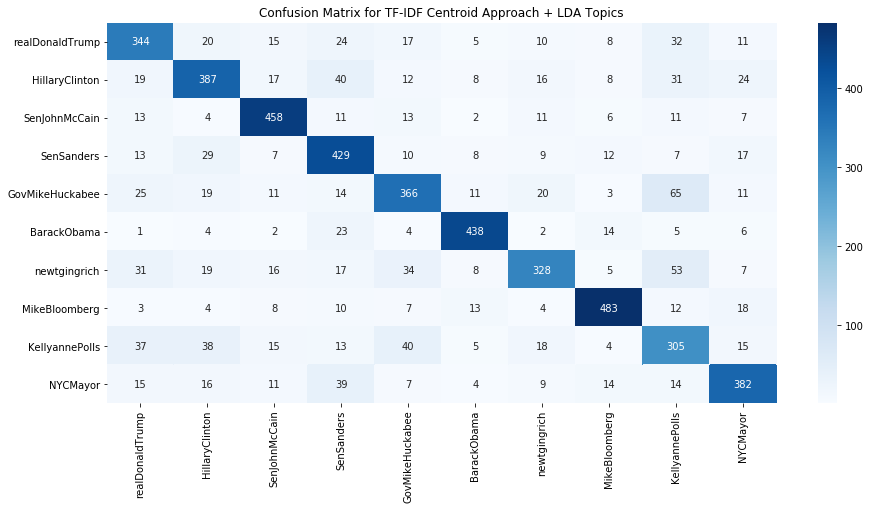

In [37]:
conf = confusion_matrix(y_test, logit_y_pred, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
plt.title('Confusion Matrix for TF-IDF Centroid Approach + LDA Topics')
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

Logistic Regression and Neural Network (MLP) have the best performance - let's fine tune both and see if we can get any incremental performance.

The below code did not finish executing after ~36 hours, so I had to cancel. This code should not be executed, but can serve as a reference for future work on this project if more CPU power was available.

In [ ]:
#Optimize the Logistic model on a few hyperparameter dimensions (keep # of combinations within reason, as model takes ~30 minutes to run for 1 iteration)

tuned_parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [0.1, 1, 10]}]
 
gscv2 = GridSearchCV(estimator = LogisticRegression(), param_grid = tuned_parameters, cv = 2, n_jobs = -1)
gscv2.fit(X_test_new_lda, y_test)
gscv2.best_estimator_

In [ ]:
gscv2.best_score_

In [ ]:
#Optimize the MLP model on a few hyperparameter dimensions (keep # of combinations within reason, as model takes ~30 minutes to run for 1 iteration)

full_x = X_train_new_lda.append(X_test_new_lda)
full_y = y_train.append(y_test)

tuned_parameters = [{'hidden_layer_sizes': [(10,10), (100,1), (100,100)],
                     'activation': ['relu', 'logistic', 'tanh'],
                     'alpha': [0.00001, 0.0001, 0.001]}]
 
gscv = GridSearchCV(estimator = neural_network.MLPClassifier(), param_grid = tuned_parameters, cv = 2, n_jobs = -1)
gscv.fit(full_x, full_y)
gscv.best_estimator_

In [ ]:
gscv.best_score_

# (Appendix) Mean-Shift

Mean-shift was not able to produce a number of clusters that could intuitively be used as topics/clusters. The algorithm produced 749 clusters on 5,250 training observations, even with bandwidth set high at 0.99. Hence no further analysis was attempted with this unsupervised clustering technique.

In [ ]:
#Benefits of mean-shift: Makes no assumptions about the number of clusters, clusters don't have to be the same size, 
#and can have non-flat geometry (clusters based on m features that cannot be separated by a straight line or plane in the
#m -dimensional space)

#Try using a 25% training sample to get cluster centers.... using 75% takes too long to run.

# Declare and fit the model. Begin with high bandwidth to cut down on number of clusters, hopefully we can make sense of them
#this way

#bandwidth = estimate_bandwidth(X_norm_tfidf.toarray(), quantile=0.2, n_samples=500)

ms_X_train, ms_X_test = train_test_split(tweet_df['Tweets'], test_size = 0.75, random_state = 42)
ms_X_train_tfidf_norm = normalize(vectorizer1.fit_transform(ms_X_train))
ms_X_test_tfidf_norm = normalize(vectorizer1.transform(ms_X_test))

ms = MeanShift(bandwidth=0.99, bin_seeding=True, n_jobs = -1)
ms.fit(ms_X_train_tfidf_norm.toarray())

# Extract cluster assignments for each data point.
labels = ms.labels_
ms_preds = ms.predict(ms_X_test_tfidf_norm.toarray())

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

In [271]:
print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 749
